## This notebook shows how to use Orchestrator APIs for user experiments

In [54]:
import os
from fabrictestbed.slice_manager.slice_manager import SliceManager, Status
import json

In [55]:
credmgr_host = os.environ['FABRIC_CREDMGR_HOST']
orchestrator_host = os.environ['FABRIC_ORCHESTRATOR_HOST']
print(f"CM Host: {credmgr_host} Orchestrator Host: {orchestrator_host}")

CM Host: beta-2.fabric-testbed.net Orchestrator Host: beta-7.fabric-testbed.net


### Fabric Tokens
Fabric has 2 kinds of tokens:<br>
- Identity : required for Control/Measurement Framework APIs. Identity Token is valid upto an hour.
- Refresh : required to generate new Identity Tokens valid. Refresh Token is valid for 24 hours.

Fabric Identity token is required for Control/Measurement Framework APIs.<br>

When user logins to Jupyterhub after authenticating against CILogon, OIDC refresh token is derived. <br>
This token is available as the environment variable `CILOGON_REFRESH_TOKEN`.<br>

On the first login, we use `CILOGON_REFRESH_TOKEN` to generate new Fabric Identity Token and Fabric Refresh Token.<br>
For any subsequent use, we use Fabric Refresh Token. On every refresh, Fabric Refresh Token is changed and updated.<br>

NOTE: These steps are required for any experiments on Fabric Testbed.<br>

In [56]:
not_found=False
fabric_refresh_token=None
%store -r fabric_refresh_token

if fabric_refresh_token is None:
    fabric_refresh_token=os.environ['CILOGON_REFRESH_TOKEN']
    %store fabric_refresh_token
print("Fabric Refresh Token {}".format(fabric_refresh_token))
print("CILOGON_REFRESH_TOKEN environment variable: {}".format(os.environ['CILOGON_REFRESH_TOKEN']))

Fabric Refresh Token NB2HI4DTHIXS6Y3JNRXWO33OFZXXEZZPN5QXK5DIGIXWKMZRGIYGKNJYGA2WMZLCGI3TSNTFMM2WCNZRGJSGKYJUGU2DMP3UPFYGKPLSMVTHEZLTNBKG623FNYTHI4Z5GE3DEMJSHAYTKMZRGU3TCJTWMVZHG2LPNY6XMMROGATGY2LGMV2GS3LFHU4DMNBQGAYDAMA
CILOGON_REFRESH_TOKEN environment variable: NB2HI4DTHIXS6Y3JNRXWO33OFZXXEZZPN5QXK5DIGIXTCMTGGA2WCMZSGBSDENBYHAZDMZTEMVQTEOJUMM2GEZDGMNSWGNR7OR4XAZJ5OJSWM4TFONUFI33LMVXCM5DTHUYTMMRRGI3TQMJXHE2TQMZGOZSXE43JN5XD25RSFYYCM3DJMZSXI2LNMU6TQNRUGAYDAMBQ


## Create Slice Manager Object
Users can request tokens with different Project and Scopes by altering `project_name` and `scope` parameters in the refresh call below.

In [57]:
slice_manager = SliceManager(oc_host=orchestrator_host, cm_host=credmgr_host, 
                             refresh_token=fabric_refresh_token, project_name='all', scope='all')

### Get new Fabric Identity Token and update Fabric Refresh Token


In [58]:
try:
    id_token, refresh_token = slice_manager.refresh_tokens()
except Exception as e:
    print("Exception occurred while getting tokens:{}".format(e))

fabric_refresh_token=slice_manager.get_refresh_token()
print()
print("New Refresh Token: {}".format(fabric_refresh_token))
print()
print("Stored new Refresh Token")
%store fabric_refresh_token
print()
print()


New Refresh Token: NB2HI4DTHIXS6Y3JNRXWO33OFZXXEZZPN5QXK5DIGIXTEODCMQYWMMDGHAZDOZJSMY3GCYJTMMYTAZJZMFTGCMJRG5QTKNZ7OR4XAZJ5OJSWM4TFONUFI33LMVXCM5DTHUYTMMRRGI4DENZZGY2DIMZGOZSXE43JN5XD25RSFYYCM3DJMZSXI2LNMU6TQNRUGAYDAMBQ

Stored new Refresh Token
Stored 'fabric_refresh_token' (str)




### Orchestrator API example to query for available resources

In [59]:
status, advertised_topology = slice_manager.resources()

print(f"Status: {status}")
if status == Status.OK:
    print(f"Toplogy: {advertised_topology}")

Status: Status.OK
Toplogy: RENC: { cpu: 6/6, core: 96/96, ram: 1536/1536G, disk: 109600/109600G, unit: 3/3, }
	Components:
		NVME-P4510:  NVME P4510 { disk: 10000/10000G, unit: 10/10, }
		GPU-RTX6000:  GPU RTX6000 { unit: 2/2, }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4, }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 3/3, }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2, }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2, }
	Site Interfaces:
UKY: { cpu: 6/6, core: 96/96, ram: 1536/1536G, disk: 109600/109600G, unit: 3/3, }
	Components:
		GPU-RTX6000:  GPU RTX6000 { unit: 2/2, }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4, }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 3/3, }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2, }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2, }
		NVME-P4510:  NVME P4510 { disk: 10000/10000G, unit: 10/10, }
	Site Interfaces:
LBNL: { cpu: 6/6, core: 96/96, ram: 1536/1536G, disk: 109600/109600G, unit: 3/3, }
	Co

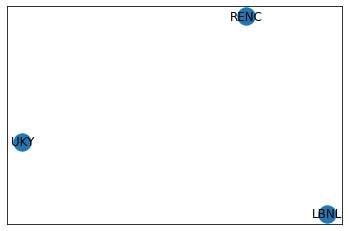

In [60]:
if status == Status.OK:
    advertised_topology.draw()

## Create Slice

In [61]:
from fabrictestbed.slice_editor import ExperimentTopology, Capacities, ComponentType
# Create topology
t = ExperimentTopology()

# Add node
n1 = t.add_node(name='n1', site='RENC')

# Set capacities
cap = Capacities()
cap.set_fields(core=4, ram=64, disk=500)

# Set Properties
n1.set_properties(capacities=cap, image_type='qcow2', image_ref='default_centos_8')

# Add PCI devices
n1.add_component(ctype=ComponentType.SmartNIC, model='ConnectX-5', name='nic1')

# Add node
n2 = t.add_node(name='n2', site='UKY')

# Set properties
n2.set_properties(capacities=cap, image_type='qcow2', image_ref='default_centos_8')

# Add PCI devices
n2.add_component(ctype=ComponentType.GPU, model='Tesla T4', name='nic2')

# Add node
n3 = t.add_node(name='n3', site='LBNL')

# Set properties
n3.set_properties(capacities=cap, image_type='qcow2', image_ref='default_centos_8')

# Add PCI devices
n3.add_component(ctype=ComponentType.GPU, model='Tesla T4', name='nic3')

# Generate Slice Graph
slice_graph = t.serialize()

ssh_key = None
with open ("/home/fabric/.ssh/id_rsa.pub", "r") as myfile:
    ssh_key=myfile.read()
    ssh_key=ssh_key.strip()

# Request slice from Orchestrator
status, reservations = slice_manager.create(slice_name='JupyterSlice2', slice_graph=slice_graph, ssh_key=ssh_key)

print("Response Status {}".format(status))
if status == Status.OK:
    print("Reservations created {}".format(reservations))

Response Status Status.OK
Reservations created [{
    "graph_node_id": "95c0b106-a891-45a0-a6bf-5f5357838a39",
    "join_state": "None_",
    "lease_end": "2021-05-18 20:20:47",
    "reservation_id": "1e05b95b-81b1-4a9e-962f-db83c8fb5fb1",
    "reservation_state": "Unknown",
    "resource_type": "VM",
    "slice_id": "9cbabbcd-5053-4785-a147-ef008ae3340b"
}, {
    "graph_node_id": "1d43062b-095d-4837-820d-8b5f42a0b0c3",
    "join_state": "None_",
    "lease_end": "2021-05-18 20:20:47",
    "reservation_id": "569e993e-5628-4951-9b60-c7c9c975f757",
    "reservation_state": "Unknown",
    "resource_type": "VM",
    "slice_id": "9cbabbcd-5053-4785-a147-ef008ae3340b"
}, {
    "graph_node_id": "c5f51414-c02f-439d-b019-bfc2f6a2a0d3",
    "join_state": "None_",
    "lease_end": "2021-05-18 20:20:47",
    "reservation_id": "ae89a915-04b0-42fd-95b8-143556cdb4c3",
    "reservation_state": "Unknown",
    "resource_type": "VM",
    "slice_id": "9cbabbcd-5053-4785-a147-ef008ae3340b"
}]


In [62]:
# Set the Slice ID from output of the above command
slice_id=reservations[0].slice_id

## Query Slices

In [63]:
status, slices = slice_manager.slices()

print("Response Status {}".format(status))
if status == Status.OK:
    print("Slices {}".format(slices))

Response Status Status.OK
Slices [{
    "graph_id": "4bea52b0-0383-46f2-8ee5-0cc3fd09b6cc",
    "slice_id": "9cbabbcd-5053-4785-a147-ef008ae3340b",
    "slice_name": "JupyterSlice2",
    "slice_state": "Configuring"
}]


## Query Slice

In [64]:
status, slice_obj = slice_manager.get_slice(slice_id=slice_id)

print("Response Status {}".format(status))
if status == Status.OK:
    print("Response received {}".format(slice_obj))

Response Status Status.OK
Response received n1[VM]: { core: 4, ram: 64G, disk: 500G, }
n2[VM]: { core: 4, ram: 64G, disk: 500G, }
n3[VM]: { core: 4, ram: 64G, disk: 500G, }
Links:


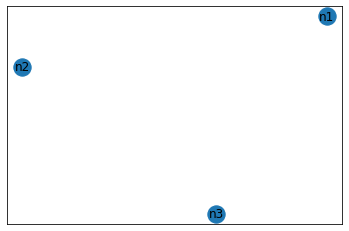

In [65]:
slice_obj.draw()

## Query Slivers

In [66]:
status, slivers = slice_manager.slivers(slice_id=slice_id)

print("Response Status {}".format(status))
if status == Status.OK:
    print("Slivers {}".format(slivers))

Response Status Status.OK
Slivers [{
    "capacities": "{\"core\": 4, \"disk\": 500, \"ram\": 64}",
    "graph_node_id": "95c0b106-a891-45a0-a6bf-5f5357838a39",
    "join_state": "NoJoin",
    "labels": "",
    "lease_end": "2021-05-18 20:20:48",
    "name": "n1",
    "reservation_id": "1e05b95b-81b1-4a9e-962f-db83c8fb5fb1",
    "reservation_state": "Ticketed",
    "resource_type": "VM",
    "site": "RENC",
    "slice_id": "9cbabbcd-5053-4785-a147-ef008ae3340b"
}, {
    "capacities": "{\"core\": 4, \"disk\": 500, \"ram\": 64}",
    "graph_node_id": "1d43062b-095d-4837-820d-8b5f42a0b0c3",
    "join_state": "NoJoin",
    "labels": "",
    "lease_end": "2021-05-18 20:20:48",
    "name": "n2",
    "reservation_id": "569e993e-5628-4951-9b60-c7c9c975f757",
    "reservation_state": "Ticketed",
    "resource_type": "VM",
    "site": "UKY",
    "slice_id": "9cbabbcd-5053-4785-a147-ef008ae3340b"
}, {
    "capacities": "{\"core\": 4, \"disk\": 500, \"ram\": 64}",
    "graph_node_id": "c5f51414-c0

In [67]:
# Set the Sliver ID from output of the above command by capturing reservation_id
sliver_id=slivers[0].reservation_id

## Query Sliver

In [68]:
status, sliver = slice_manager.slivers(slice_id=slice_id, sliver_id=sliver_id)

print("Response Status {}".format(status))
if status == Status.OK:
    print("Sliver {}".format(sliver))

Response Status Status.OK
Sliver [{
    "capacities": "{\"core\": 4, \"disk\": 500, \"ram\": 64}",
    "graph_node_id": "95c0b106-a891-45a0-a6bf-5f5357838a39",
    "join_state": "NoJoin",
    "labels": "",
    "lease_end": "2021-05-18 20:20:48",
    "name": "n1",
    "reservation_id": "1e05b95b-81b1-4a9e-962f-db83c8fb5fb1",
    "reservation_state": "Ticketed",
    "resource_type": "VM",
    "site": "RENC",
    "slice_id": "9cbabbcd-5053-4785-a147-ef008ae3340b"
}]


## Slice Status

In [69]:
import time

slice_state=None
while slice_state != 'StableOK':
    status, slice_status = slice_manager.slice_status(slice_id=slice_id)
    slice_state = slice_status.slice_state
    print("Response Status {}".format(status))
    if status == Status.OK:
        print("Slice State: {}".format(slices[0].slice_state))
    time.sleep(20)

Response Status Status.OK
Slice State: Configuring
Response Status Status.OK
Slice State: Configuring
Response Status Status.OK
Slice State: Configuring
Response Status Status.OK
Slice State: Configuring
Response Status Status.OK
Slice State: Configuring
Response Status Status.OK
Slice State: Configuring
Response Status Status.OK
Slice State: Configuring
Response Status Status.OK
Slice State: Configuring
Response Status Status.OK
Slice State: Configuring
Response Status Status.OK
Slice State: Configuring
Response Status Status.OK
Slice State: Configuring
Response Status Status.OK
Slice State: Configuring
Response Status Status.OK
Slice State: Configuring
Response Status Status.OK
Slice State: Configuring
Response Status Status.OK
Slice State: Configuring


## Sliver Status

In [70]:
for s in slivers:
    status, sliver_status = slice_manager.sliver_status(slice_id=slice_id, sliver_id=s.reservation_id)

    print("Response Status {}".format(status))
    if status == Status.OK:
        print()
        print("Sliver Status {}".format(sliver_status))
        print()

Response Status Status.OK

Sliver Status {
    "capacities": "{\"core\": 4, \"disk\": 500, \"ram\": 64}",
    "graph_node_id": "95c0b106-a891-45a0-a6bf-5f5357838a39",
    "join_state": "NoJoin",
    "labels": "",
    "lease_end": "2021-05-18 20:20:47",
    "management_ip": "152.54.15.37",
    "name": "n1",
    "notices": "Reservation 1e05b95b-81b1-4a9e-962f-db83c8fb5fb1 (Slice JupyterSlice2(9cbabbcd-5053-4785-a147-ef008ae3340b) Graph Id:4bea52b0-0383-46f2-8ee5-0cc3fd09b6cc ) is in state [Active,None_]\n\nLast ticket update: \nTicket events: \nLast ticket update: \nTicket events: ",
    "reservation_id": "1e05b95b-81b1-4a9e-962f-db83c8fb5fb1",
    "reservation_state": "Active",
    "resource_type": "VM",
    "site": "RENC",
    "slice_id": "9cbabbcd-5053-4785-a147-ef008ae3340b"
}

Response Status Status.OK

Sliver Status {
    "capacities": "{\"core\": 4, \"disk\": 500, \"ram\": 64}",
    "graph_node_id": "1d43062b-095d-4837-820d-8b5f42a0b0c3",
    "join_state": "NoJoin",
    "labels": 

## Delete Slice

In [71]:
status, result = slice_manager.delete(slice_id=slice_id)

print("Response Status {}".format(status))
if status == Status.OK:
    print("Response received {}".format(result))

Response Status Status.OK
Response received None
